In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('train.txt' , delimiter=';', names = ['text' , 'sentiment'])
val_data = pd.read_csv('val.txt' , delimiter=';', names = ['text' , 'sentiment'])
test = pd.read_csv('test.txt' , delimiter=';', names = ['text' , 'sentiment'])

In [4]:
train_data.shape, val_data.shape, test.shape

((16000, 2), (2000, 2), (2000, 2))

**Combining training set and validation set**

In [5]:
train = pd.concat([train_data, val_data] , axis = 0)
train.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
train.shape

(18000, 2)

# EDA

In [7]:
train['sentiment'] = train['sentiment'].replace({'anger': 0, 'fear' : 1, 'joy': 2, 'love' : 3, 'sadness' : 4, 'surprise': 5})
test['sentiment'] = test['sentiment'].replace({'anger': 0, 'fear' : 1, 'joy': 2, 'love' : 3, 'sadness' : 4, 'surprise': 5})

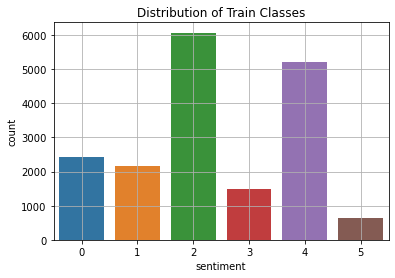

In [8]:
sns.countplot(x = train['sentiment'])
plt.grid()
plt.title("Distribution of Train Classes")
plt.show()

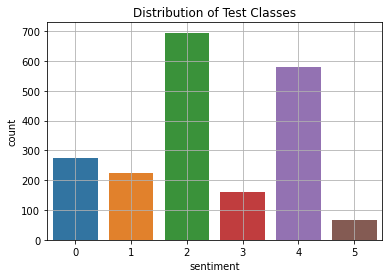

In [9]:
sns.countplot(x = test['sentiment'])
plt.grid()
plt.title("Distribution of Test Classes")
plt.show()

# Text Preprocessing

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/harry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/harry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/harry/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re

In [12]:
def transform1(data):
    ''' Getting only english characters and converting everything to lower case '''
    output = []
    for sent in data:
        out = re.sub('[^a-zA-Z]',' ',str(sent))
        out = sent.lower()
        output.append(out)
    
    return output

In [13]:
def transform2(data):
    ''' Word Lemmatization and Stopword removal '''
    lm = WordNetLemmatizer()
    output = []
    for sent in data:
        s = sent.split()
        o = []
        for word in s:
            if word not in set(stopwords.words('english')):
                o.append(lm.lemmatize(word))
        
        final = " ".join(str(x) for x in o)
        output.append(final)
        
    return output

In [14]:
def transform3(data):
    ''' Stemming of Words '''
    snow = SnowballStemmer(language='english')
    output = []
    
    for sent in data:
        s = sent.split()
        out = [snow.stem(word) for word in s]
        final = ' '.join(str(x) for x in out)
        output.append(final)
        
    return output
        

In [15]:
def text_transformation(df):
    corpus = df['text']
    t = transform1(corpus)
    t = transform2(t)
    t = transform3(t)
    return t

In [16]:
train['preprocessed_text'] = text_transformation(train)

In [17]:
test['preprocessed_text'] = text_transformation(test)

In [18]:
train.head()

,text,sentiment,preprocessed_text
0,i didnt feel humiliated,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,feel grouchi


# Text Vectorization

## Bag of Words

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (1,3))
cv.fit(train['preprocessed_text'])
print(len(cv.vocabulary_))

232389


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range = (1,3), max_features = 2000)
train_bow = vect.fit_transform(train['preprocessed_text'])
test_bow = vect.transform(test['preprocessed_text'])

In [21]:
train_bow.shape, test_bow.shape

((18000, 2000), (2000, 2000))

## TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer( ngram_range = (1,3), max_features = 2000 )
train_tf = tfidf.fit_transform(train['preprocessed_text'])
test_tf = tfidf.transform(test['preprocessed_text'])

In [23]:
train_tf.shape

(18000, 2000)

In [24]:
test_tf.shape

(2000, 2000)

## TFIDF - W2V

In [25]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())

In [26]:
tf = TfidfVectorizer()
tf.fit(train['text'])

idf_dict = dict(zip(tf.vocabulary_, list(tf.idf_)))
idf_words = set(tf.vocabulary_)

In [27]:
def tfidf_w2v(df):
    
    output = []

    for sent in df['text']:
        vector = np.zeros(300)
        tf_idf_weight = 0

        for word in sent.split():
            if (word in glove_words) and (word in idf_words):
                vec = glove[word]   # glove vector for the word
                tf_idf = idf_dict[word]*(sent.count(word)/len(sent.split())) # tf_idf value of a word

                vector += vec * tf_idf
                tf_idf_weight += tf_idf

        if tf_idf_weight != 0:
            vector = vector / tf_idf_weight

        output.append(vector)
    
    return np.array(output)

In [28]:
train_w2v = tfidf_w2v(train)
test_w2v = tfidf_w2v(test)

In [29]:
train_w2v.shape , test_w2v.shape

((18000, 300), (2000, 300))

# Modelling

In [33]:
from sklearn.metrics import roc_auc_score
def fit_model(model, X_train, y_train):
    Xtrain, ytrain = X_train[:16000] , y_train[:16000]
    Xval, yval = X_train[16000:], y_train[16000:]
    
    model.fit(Xtrain,ytrain)
    
    pred = model.predict_proba(Xval)
    
    auc = roc_auc_score(yval , pred, average='weighted', multi_class = 'ovr')
    
    return auc

In [34]:
y_train = train['sentiment']
y_test = test['sentiment']

## Naive Bayes

In [35]:
# Using BoW
from sklearn.naive_bayes import MultinomialNB
nb_bow = MultinomialNB()

fit_model(nb_bow, train_bow, y_train)

0.9725751972179391

In [36]:
# Using Tf-Idf
nb_tfidf = MultinomialNB()
fit_model(nb_tfidf , train_tf, y_train)

0.974825675390396

In [37]:
from sklearn.naive_bayes import GaussianNB
nb_w2v = GaussianNB()
fit_model(nb_w2v , train_w2v, y_train)

0.6930810589948116

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param = {'alpha' : [0.001,0.05,0.01,0.1, 0.5, 1, 3]}

grid = GridSearchCV( MultinomialNB() , 
                     param_grid = param,
                     cv = 5,
                     scoring = 'roc_auc_ovr_weighted',
                     n_jobs = -1,
                     return_train_score = True)

grid.fit(train_bow, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.05, 0.01, 0.1, 0.5, 1, 3]},
             return_train_score=True, scoring='roc_auc_ovr_weighted')

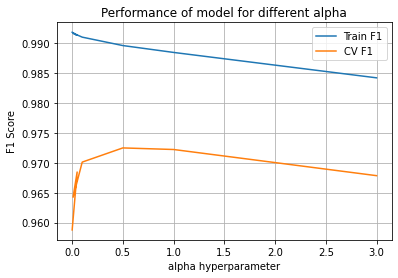

In [39]:
x_axis = [0.001,0.05,0.01,0.1, 0.5, 1,3]

grid_results = grid.cv_results_
cv_score = grid_results['mean_test_score']
train_score = grid_results['mean_train_score']

plt.plot(x_axis, train_score , label='Train F1')
plt.plot(x_axis, cv_score , label='CV F1')

plt.legend()
plt.xlabel("alpha hyperparameter")
plt.ylabel("F1 Score")
plt.title("Performance of model for different alpha")
plt.grid()
plt.show()

In [40]:
best_model = MultinomialNB(alpha = 0.5)
best_model.fit(train_bow, y_train)

MultinomialNB(alpha=0.5)

In [43]:
y_pred = best_model.predict_proba(test_bow)
print(" Test AUC score: ", roc_auc_score(y_test , y_pred, average = 'weighted', multi_class = 'ovr'))

 Test AUC score:  0.9789631375393223


## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_bow = RandomForestClassifier()
fit_model(rf_bow , train_bow, y_train)

0.9732043968790174

In [45]:
rf_tfidf = RandomForestClassifier()
fit_model(rf_tfidf , train_tf, y_train)

0.9718207709457954

In [46]:
rf_w2v = RandomForestClassifier()
fit_model(rf_w2v , train_w2v, y_train)

0.7613044697226459

In [53]:
from sklearn.model_selection import GridSearchCV

param = {'max_depth' : [2,4,6,8],
         'n_estimators': [50, 100, 150, 200]}

grid = GridSearchCV( RandomForestClassifier() , 
                     param_grid = param,
                     cv = 3,
                     scoring = 'roc_auc_ovr_weighted',
                     n_jobs = -1,
                     return_train_score = True)

grid.fit(train_tf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='roc_auc_ovr_weighted')

In [54]:
grid_output = pd.DataFrame()
grid_results = grid.cv_results_

grid_output['max_depth'] = np.array(grid_results['param_max_depth'])
grid_output['n_estimators'] = np.array( grid_results['param_n_estimators'])
grid_output['cv_score'] = np.array(grid_results['mean_test_score'])
grid_output['train_score'] = np.array(grid_results['mean_train_score'])

/home/harry/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:xlabel='max_depth', ylabel='n_estimators'>

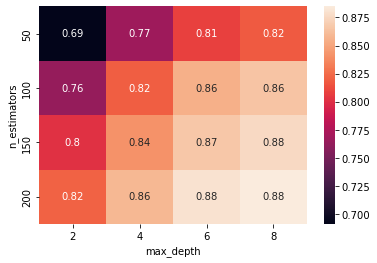

In [55]:
df_cv = grid_output.pivot("n_estimators", "max_depth", "cv_score")
sns.heatmap(df_cv, annot = True)

<AxesSubplot:xlabel='max_depth', ylabel='n_estimators'>

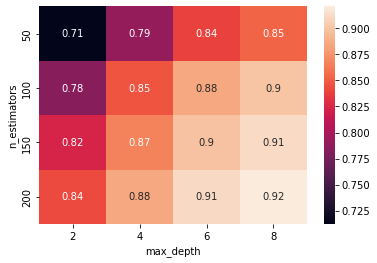

In [56]:
df_train = grid_output.pivot("n_estimators", "max_depth", "train_score")
sns.heatmap(df_train, annot = True)

In [59]:
best_model = RandomForestClassifier(max_depth = 8 , n_estimators = 200)
best_model.fit(train_tf, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200)

In [61]:
y_pred = best_model.predict_proba(test_tf)
print(" Test AUC score: ", roc_auc_score(y_test , y_pred, average = 'weighted', multi_class = 'ovr'))

 Test AUC score:  0.8803824381419638


## GBDT

In [65]:
import xgboost as xgb
from xgboost import XGBClassifier
xgb_bow = XGBClassifier()
fit_model(xgb_bow, train_bow, y_train)

/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9802338829041147

In [66]:
xgb_tf = XGBClassifier()
fit_model(xgb_tf, train_tf, y_train)

/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9768754193225073

In [67]:
xgb_w2v = XGBClassifier()
fit_model(xgb_w2v, train_w2v, y_train)

/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.851895992866493

In [68]:
param = {'max_depth' : [2,4,6,8],
         'eta': [0.2, 0.4, 0.6, 0.8]}

grid = GridSearchCV( XGBClassifier(use_label_encoder=False) , 
                     param_grid = param,
                     cv = 3,
                     scoring = 'roc_auc_ovr_weighted',
                     n_jobs = -1,
                     return_train_score = True)

grid.fit(train_bow, y_train)

/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with

[11:12:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [69]:
grid_output = pd.DataFrame()
grid_results = grid.cv_results_

grid_output['max_depth'] = np.array(grid_results['param_max_depth'])
grid_output['eta'] = np.array( grid_results['param_eta'])
grid_output['cv_score'] = np.array(grid_results['mean_test_score'])
grid_output['train_score'] = np.array(grid_results['mean_train_score'])

/home/harry/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:xlabel='max_depth', ylabel='eta'>

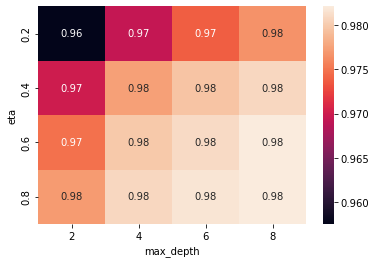

In [70]:
df_cv = grid_output.pivot("eta", "max_depth", "cv_score")
sns.heatmap(df_cv, annot = True)

<AxesSubplot:xlabel='max_depth', ylabel='eta'>

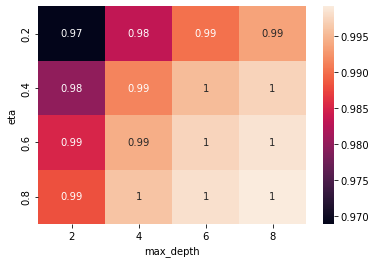

In [71]:
df_train = grid_output.pivot("eta", "max_depth", "train_score")
sns.heatmap(df_train, annot = True)

In [72]:
best_model = XGBClassifier(max_depth = 4, eta = 0.6)
best_model.fit(train_bow , y_train)

/home/harry/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.6, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.600000024,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [75]:
y_pred = best_model.predict_proba(test_bow)
print(" Test AUC score: ", roc_auc_score(y_test , y_pred, average = 'weighted', multi_class = 'ovr'))

 Test AUC score:  0.9794162055294194
[11:10:26] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:11:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:26] W